In [1]:
# 라이브러리

import pandas as pd ; pd.options.display.float_format = '{:.2f}'.format # 소수 둘째자리까지 표시
import numpy as np
import math

import time
from time import sleep
import random
import datetime
from datetime import datetime, timedelta, datetime
import json

from string import ascii_lowercase

import collections
from dateutil.relativedelta import relativedelta

from powernad.API.Campaign import *
from powernad.API.RelKwdStat import *

from urllib.error import HTTPError
import urllib.request

from bs4 import BeautifulSoup ; import bs4
from selenium import webdriver
import psycopg2
import re

from tqdm.notebook import tqdm

import requests; from urllib.parse import urlparse
import seaborn as sns; sns.set(style='darkgrid', font='NanumGothic', font_scale=1.2) ; sns.set_color_codes()

import matplotlib; import matplotlib.pyplot as plt

import squarify


# 네트워크 시각화용
import warnings
warnings.filterwarnings(action='ignore')

from matplotlib import font_manager, rc
from matplotlib import style
style.use('ggplot')
%matplotlib inline


font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf", size=20).get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

# 구간날짜 변수 생성

In [2]:
"""
날짜 구간 정보가 들어있는 변수들을 생성합니다.
이 변수들을 활용해 날짜 구간을 기준으로 매일 데이터를 갱신합니다.
...
----------------------------------
today = 현재
today = 오늘자 년월일 문자열
yesterday = 어제 
time_week = 7일 전
time_month = 1개월 전
time_year = 1년 전
time_two_years = 2년 전
time_three_years = 3년 전
"날짜구간 변수명"_index = 날짜구간 인덱스
dt_"날짜구간" = 날짜구간 인덱스를 리스트 형태로 
"""

# 오늘
toda = datetime.now()
today = str(datetime.now().date()) # 


# 1일 전
yesterday = toda - relativedelta(days=1)
yesterday = yesterday.strftime('%Y-%m-%d')
yesterday = str(yesterday)


# 1주
time_week = toda - relativedelta(weeks=1)
time_week = time_week.strftime('%Y-%m-%d')
time_week = str(time_week)
# 최근 1주 리스트
week_index = pd.date_range(start=time_week, end= yesterday)
dt_week = week_index.strftime("%Y-%m-%d").tolist()


# 1개월
time_month = toda - relativedelta(months=1)
time_month = time_month.strftime('%Y-%m-%d')
time_month= str(time_month)
# 최근 1개월 리스트
month_index = pd.date_range(start=time_month, end= yesterday)
dt_month = month_index.strftime("%Y-%m-%d").tolist()


# 1년
time_year = toda - relativedelta(years=1)
time_year = time_year.strftime('%Y-%m-%d')
time_year= str(time_year)
# 최근 1년 리스트
year_index = pd.date_range(start=time_year, end= yesterday)
dt_year = year_index.strftime("%Y-%m-%d").tolist()


# 2년
time_two_years = toda - relativedelta(years=2)
time_two_years = time_two_years.strftime('%Y-%m-%d')
time_two_years = str(time_two_years)
# 최근 2년 리스트
two_years_index = pd.date_range(start=time_two_years, end= yesterday)
dt_two_years = two_years_index.strftime("%Y-%m-%d").tolist()

# 3년
time_three_years = toda - relativedelta(years=3)
time_three_years = time_three_years.strftime('%Y-%m-%d')
time_three_years = str(time_three_years)
# 최근 3년 리스트
three_years_index = pd.date_range(start=time_three_years, end= yesterday)
dt_three_years = three_years_index.strftime("%Y-%m-%d").tolist()

In [4]:
# df_origin
"""
네이버 데이터랩 쇼핑인사이트 기준 일자별 도서 카테고리 검색랭킹 500위에 포함된 키워드 정보가 있는 데이터프레임입니다.
데이터 시작일 = 2021-05-10 (패션의류, 가구에 비해 데이터 제공 시점이 늦음)
...
rank = 일자별 네이버 데이터랩 검색어 랭킹 (1 ~ 500)
keyword = 검색어 이름
year = 검색어 랭크인한 년도 정보
month = 검색어 랭크인한 월 정보
day = 검색어 랭크인한 일자 정보
ymd = 검색어 랭크인한 당일 년월일 정보
"""
df_origin = pd.read_csv('C:/project/CODE/keyword/data/book/naver_top_500/' + yesterday + '_naver_book_updated.csv', header = None, encoding='utf-8', index_col=0)
df_origin.columns = ['rank', 'keyword', 'year', 'month', 'day', 'ymd']
df_origin = df_origin.sort_values(by=['ymd', 'rank'])
df_origin = df_origin.reset_index(drop=True)
df_origin

,rank,keyword,year,month,day,ymd
0,1,귀멸의칼날만화책,2021,5,10,2021-05-10
1,2,튤립사운드북,2021,5,10,2021-05-10
2,3,뽀로로사운드카드,2021,5,10,2021-05-10
3,4,귀멸의칼날23권한정판,2021,5,10,2021-05-10
4,5,하이큐만화책,2021,5,10,2021-05-10
...,...,...,...,...,...,...
188954,496,어스본사운드북세트,2022,6,10,2022-06-10
188955,497,역사1평가문제집동아,2022,6,10,2022-06-10
188956,498,영양사문제집,2022,6,10,2022-06-10
188957,499,영어단어책,2022,6,10,2022-06-10


In [5]:
# df
"""
개별 키워드들의 날짜 정보가 가장 오래된(키워드가 최초 랭크인한 날) 행을 1개만 남기고 나머지 중복값을 모두 삭제한 데이터프레임입니다.
기존에 검색어 랭킹 500위 이내에 없던 키워드가 최초로 랭크된 것은 순간적으로 해당 키워드에 대한 관심도가 증가했다고 볼 수 있습니다.
...
rank = 일자별 네이버 데이터랩 검색어 랭킹 (1 ~ 500)
keyword = 검색어 이름
year = 검색어 랭크인한 년도 정보
month = 검색어 랭크인한 월 정보
day = 검색어 랭크인한 일자 정보
ymd = 검색어 랭크인한 당일 년월일 정보
"""

df = df_origin.drop_duplicates(['keyword'], keep='first')
df = df.reset_index(drop=True)
df

,rank,keyword,year,month,day,ymd
0,1,귀멸의칼날만화책,2021,5,10,2021-05-10
1,2,튤립사운드북,2021,5,10,2021-05-10
2,3,뽀로로사운드카드,2021,5,10,2021-05-10
3,4,귀멸의칼날23권한정판,2021,5,10,2021-05-10
4,5,하이큐만화책,2021,5,10,2021-05-10
...,...,...,...,...,...,...
10757,483,해범이의모험,2022,6,10,2022-06-10
10758,486,국민연금공단봉투모의고사,2022,6,10,2022-06-10
10759,489,머리가좋아지는다면체종이접기,2022,6,10,2022-06-10
10760,491,미래엔중국어자습서,2022,6,10,2022-06-10


In [13]:
# df_monthly_keywords
"""
최초등장일이 최근 1개월 이내인 키워드들만 보여주는 데이터프레임입니다.
...
rank = 일자별 네이버 데이터랩 검색어 랭킹 (1 ~ 500)
keyword = 검색어 이름
year = 검색어 랭크인한 년도 정보
month = 검색어 랭크인한 월 정보
day = 검색어 랭크인한 일자 정보
ymd = 검색어 랭크인한 당일 년월일 정보
"""

df_monthly_keywords = df.query('ymd == @dt_month')
df_monthly_keywords = df_monthly_keywords.reset_index(drop=True)
df_monthly_keywords 



########################################### 1개월 이내 필터링만 적용 시 1400개가 나와서 랭크 150 이내로 한번 더 걸러보자...
df_monthly_keywords = df_monthly_keywords[df_monthly_keywords['rank'] < 150]
########################################### 테스트용이니 아니다 싶으면 까먹지말고 삭제해라

In [14]:
# lis
"""
최초등장일이 최근 1개월 이내인 키워드들이 담긴 리스트를 생성합니다.
"""
lis = list(df_monthly_keywords['keyword'])
len(lis)

131

# 키워드 검색량 조회용 네이버 API

In [15]:
# Naver API 조회용 기본 설정
"""
네이버 광고 API 정보를 조회하기 위한 변수입니다.
...
BASE_URL = 네이버 API 주소
API_KEY = 네이버 검색광고 API 엑세스 라이선스
SECRET_KEY = 네이버 검색광고 API SECRET
CUSTOMER_ID = 네이버 검색광고 API ID
rel = 클라이언트 정보 저장 변수
"""

BASE_URL = 'https://api.naver.com'
API_KEY = '01000000000fcd1ce283f84b5b3f32330368ac6dce35c5a8e3feabf4cfec31ae32b7e9d0e8'
SECRET_KEY = 'AQAAAAAPzRzig/hLWz8yMwNorG3OPks1JGYBp40Ib+rqqydacA=='
CUSTOMER_ID = '2488417'
rel = RelKwdStat(BASE_URL, API_KEY, SECRET_KEY, CUSTOMER_ID)

In [16]:
# search_keyword
def search_keyword(searchword):
    """
    네이버 API 키워드 월간 검색수를 반환해주는 함수입니다.
    ...
    searchword = API 정보를 조회할 키워드명
    """
    
    # kwdDataList = 키워드 검색 정보를 담은 변수입니다.
    kwdDataList = rel.get_rel_kwd_stat_list(siteId=None, biztpId=None, hintKeywords=searchword, event=None, month=None, showDetail='1')

    # kwd_result
    
    '''
    kwdDataList[0].relKeyword = 키워드
    kwdDataList[0].monthlyPcQcCnt = 월간 검색수 (PC)
    kwdDataList[0].monthlyMobileQcCnt = 월간 검색수 (Mobile)
    kwdDataList[0].monthlyPcQcCnt+kwdDataList[0].monthlyMobileQcCnt = 월간 검색수 (total)
    '''
    kwd_result = (kwdDataList[0].relKeyword,
                 kwdDataList[0].monthlyPcQcCnt,
                 kwdDataList[0].monthlyMobileQcCnt,
                 kwdDataList[0].monthlyPcQcCnt+kwdDataList[0].monthlyMobileQcCnt)
    
    # kwd_result[3] = 검색한 키워드명과 월간 pc, 모바일, 총 검색수를 반환합니다
    return(kwd_result[3])

# 네이버 데이터랩 (검색어트렌드) 클라이언트 정보
'''
client_id = 네이버 데이터랩 (검색어트렌드) id
client_secret = 네이버 데이터랩 (검색어트렌드) secret
'''
client_id = "IZr05hqQauLB_l9gJEFG"  
client_secret = "cARLdhpO5W"  

In [17]:
# 키워드별 검색량 저장용 자료구조 생성
'''
dictionary_yester = 전일 키워드 검색량 / 딕셔너리
dictionary_now = 오늘자 키워드 검색량  / 딕셔너리
error = 에러 확인 / 리스트
df_total = 일자별 키워드 검색량 / 데이터프레임
'''
dictionary_yester={}
dictionary_now={}
error=[]
df_total = pd.DataFrame(columns=['키워드', '날짜', '수집날짜', '검색량'])


In [18]:
# serach_query
def search_query(list_name):
    """
    위에서 선언한 search_keyword() 함수를 통해 각 키워드의 월간 총 검색량을 추출한 후, 
    날짜별 검색량으로 전환한 데이터프레임을 생성하는 함수입니다.
    ...
    list_name = 조회하고 싶은 키워드 정보가 들어있는 리스트 이름
    """
    
    global df_total
    for i in tqdm(list_name):  
        print(i)
        sleep(1)
        try:
            if type(search_keyword(i)) !=str : 
                searchword = i.replace(" ","")
                a = search_keyword(searchword)


                url = "https://openapi.naver.com/v1/datalab/search"
                body = "{\"startDate\":\""+time_month+"\",\"endDate\":\""+today+"\",\"timeUnit\":\"date\",\"keywordGroups\":[{\"groupName\":\""+i+"\",\"keywords\":[\""+i+"\"]}]}";
                requested = urllib.request.Request(url)
                requested.add_header("X-Naver-Client-Id", client_id)
                requested.add_header("X-Naver-Client-Secret", client_secret)
                requested.add_header("Content-Type", "application/json")
                response = urllib.request.urlopen(requested, data=body.encode("utf-8"))
                rescode = response.getcode()

                if(rescode==200):
                    response_body = response.read()
                    output_data = response_body.decode('utf-8')
                else:
                    print('Error code:'+ rescode)
                    pass

                # result = API 조회 결과값이 들어있는 변수입니다.
                result = json.loads(output_data)

                # date = a['period'] 에서 최근 1개월간의 날짜 값들을 추출한 리스트를 생성합니다.
                date = [a['period'] for a in result['results'][0]['data']]

                # aa = 날짜와 날짜별 검색량을 추출한 데이터프레임을 생성합니다.
                aa = pd.DataFrame({'date':date, 
                              'querycount':[a['ratio'] for a in result['results'][0]['data']],
                              })

                # 일일 데이터 계산 
                sleep(0.5)
                total = aa['querycount'].sum() 
                
                # 30일간 모든 백분율 값을 더한 후 일자별 실제 검색량을 반환합니다.
                '''
                total = 날짜별 모든 백분율 검색량을 더한 값
                float(a) = 월간 총 검색량 실수화
                x = 각 일자별 검색량
                '''
                aa['검색량'] = aa['querycount'].apply(lambda x :((x / total)*float(a))) 
                # aa (일자별 검색량) = (일일 검색률 / 30일간 백분율 총합) * 월간 총검색량


            else : 
                pass

        except (TypeError, IndexError,KeyError,ValueError):
            print(" 타입 or 인덱스 에러,Value 에러:",i)
            error.append(i)
            pass


        except HTTPError:
            print('http 에러:', i )
            error.append(i)
            pass

            #여기부터 새로 코딩
        try: 
            if type(search_keyword(i)) !=str : 
                searchword = i.replace(" ","")
                a = search_keyword(searchword)        


                date = pd.DataFrame(data=dt_month, columns=['날짜'])

                spred = pd.merge(date,aa,left_on='날짜',right_on='date',how='outer')
                spred.drop(['date'],inplace=True, axis=1)

                spred.replace(np.nan,0,inplace=True)


                a=[] 

                for j in range(len(spred)) : 
                    a.append(today)


                spred['수집날짜'] = a
                spred['키워드'] = i
                spred = spred[['키워드', '날짜','수집날짜', '검색량']]

                if i in dictionary_yester:

                    pass

                else : 
                    dictionary_yester[i]=[]



                dictionary_now[i]=spred
                df_total = pd.concat([df_total, spred])

            else:
                pass

        except (TypeError, IndexError,KeyError,ValueError):

            pass

        sleep(0.5)
        try :
            if type(search_keyword(i)) !=str : 
                searchword = i.replace(" ","")
                a = search_keyword(searchword)        

                if dictionary_yester[i]==[]:
                    dictionary_yester[i] = dictionary_now[i]

                else : 
                    pass 
            else:
                pass


        except (TypeError, IndexError,KeyError):
              pass


        except ValueError:


                yester_df= dictionary_yester[i]
                today_df = dictionary_now[i]


                yester_df.set_index('날짜',inplace=True)

                today_df.set_index('날짜',inplace=True)

                yester_df.update(today_df)


                tmpt = today_df.iloc[-1,:]

                yester_df = yester_df.append(tmpt)

                yester_df.reset_index(inplace=True)
                today_df.reset_index(inplace=True)


                dictionary_yester[i] = yester_df


        except :
            print('API 에러',i)
            error.append(i)



        sleep(3)

    df_total['검색량'] = df_total['검색량'].astype(int)
    
    df_total.to_csv('C:/project/CODE/keyword/data/book/query/' + yesterday + '_month_book_query_by_date.csv', encoding='UTF-8')
    
    return(df_total)

In [20]:
search_query(lis)

  0%|          | 0/131 [00:00<?, ?it/s]

기타이유식용품
인플레이션에서살아남기
성경암송찬양사운드북조이챈트폰joychant말씀송
 타입 or 인덱스 에러,Value 에러: 성경암송찬양사운드북조이챈트폰joychant말씀송
진짜헨젤과그레텔이야기
매3화법과작문연합도서수능기출책키출판사
 타입 or 인덱스 에러,Value 에러: 매3화법과작문연합도서수능기출책키출판사
중학교문학
인체탐험대
소마셈k단계수학
중국어회화
이토록공부가재미있어지는순간
수제비정보처리기사
수학자들이들려주는수학이야기
사운드북성경
 타입 or 인덱스 에러,Value 에러: 사운드북성경
스팟라이트온퍼스트파닉스
 타입 or 인덱스 에러,Value 에러: 스팟라이트온퍼스트파닉스
그리스로마신화세트
 타입 or 인덱스 에러,Value 에러: 그리스로마신화세트
브릭스리딩초등
 타입 or 인덱스 에러,Value 에러: 브릭스리딩초등
이퓨쳐스마트파닉스sb
 타입 or 인덱스 에러,Value 에러: 이퓨쳐스마트파닉스sb
생각이크는인문학
생각이크는인문학세트
 타입 or 인덱스 에러,Value 에러: 생각이크는인문학세트
오라클
한자능력검정시험6급
한자옥편
도서서브젝트링크
 타입 or 인덱스 에러,Value 에러: 도서서브젝트링크
코레일봉투모의고사
소방전술
소년탐정김전일
박문각주택관리사
주택관리사에듀윌
주택관리사기출문제집
나의히어로아카데미아33
나의히어로아카데미아33권
포터스타일5년후나에게q&amp;aaday
 타입 or 인덱스 에러,Value 에러: 포터스타일5년후나에게q&amp;aaday
개념원리고등수학하2021
 타입 or 인덱스 에러,Value 에러: 개념원리고등수학하2021
따따부따마켓
추리천재엉덩이탐정10-사랑의포로사건-아이세움
 타입 or 인덱스 에러,Value 에러: 추리천재엉덩이탐정10-사랑의포로사건-아이세움
개념원리고등학교rpm알피엠수학22022
 타입 or 인덱스 에러,Value 에러: 개념원리고등학교rpm알피엠수학22022
우리아기오감발달시끌벅적정글사운드북
 타입 or 인덱스 에러,Value 에러: 우리아기오감발달시끌벅적정글사운드북
고고카카오프렌즈

,키워드,날짜,수집날짜,검색량
0,인플레이션에서살아남기,2022-05-11,2022-06-11,678
1,인플레이션에서살아남기,2022-05-12,2022-06-11,332
2,인플레이션에서살아남기,2022-05-13,2022-06-11,168
3,인플레이션에서살아남기,2022-05-14,2022-06-11,166
4,인플레이션에서살아남기,2022-05-15,2022-06-11,154
...,...,...,...,...
26,란이는한창충전중,2022-06-06,2022-06-11,0
27,란이는한창충전중,2022-06-07,2022-06-11,0
28,란이는한창충전중,2022-06-08,2022-06-11,0
29,란이는한창충전중,2022-06-09,2022-06-11,11


In [21]:
# df_query
"""
네이버 도서 탑 500 에 신규진입한 키워드의 최근 1개월 동안의 일자별 검색량이 있는 데이터프레임입니다.
"""
df_query = df_total
df_query = df_query[['키워드', '날짜', '수집날짜', '검색량']]
df_query = df_query.rename(columns={'키워드':'keyword', '날짜':'ymd', '수집날짜':'search_date', '검색량': 'query'})
df_query['query'] = df_query['query'].astype(int)
df_query

,keyword,ymd,search_date,query
0,인플레이션에서살아남기,2022-05-11,2022-06-11,678
1,인플레이션에서살아남기,2022-05-12,2022-06-11,332
2,인플레이션에서살아남기,2022-05-13,2022-06-11,168
3,인플레이션에서살아남기,2022-05-14,2022-06-11,166
4,인플레이션에서살아남기,2022-05-15,2022-06-11,154
...,...,...,...,...
26,란이는한창충전중,2022-06-06,2022-06-11,0
27,란이는한창충전중,2022-06-07,2022-06-11,0
28,란이는한창충전중,2022-06-08,2022-06-11,0
29,란이는한창충전중,2022-06-09,2022-06-11,11


In [22]:
# df_query_sum
"""
신규키워드들의 최근 1개월 누적 검색량이 있는 데이터프레임입니다.
"""
df_query_sum = df_query[['keyword', 'query']].groupby('keyword').sum()
df_query_sum = df_query_sum.rename(columns = {'query':'query_month'})
df_query_sum.sort_values('query_month', ascending=False)

,query_month
keyword,
나이스,192687
따따부따마켓,57332
알고리즘,37484
오라클,31590
이예선,27791
...,...
성안당수질환경기사,79
공조냉동기술사일진사,59
통기타악보집,40


In [27]:
# df_query_m
"""
최근 1개월 이내에 키워드 검색 탑 500에 등장한 키워드들의 검색량을 보여주는 데이터프레임입니다.
...
query = 신규 키워드 랭크 진입 당일 검색량
query_month = 신규 키워드의 최근 1개월 누적 검색량
"""

df_query_m = pd.merge(df_monthly_keywords, df_query, on='keyword')
df_query_m = pd.merge(df_query_m, df_query_sum, on = 'keyword')
df_query_m = df_query_m[df_query_m['ymd_x'] == df_query_m['ymd_y']]
df_query_m = df_query_m.drop(['ymd_y'], axis=1).sort_values(['ymd_x', 'rank'])
df_query_m.rename(columns = {'ymd_x':'ymd'},inplace=True)
df_query_m.reset_index(inplace=True, drop=True)

df_query_m.sort_values(['query_month'], ascending=False).head(50)

,rank,keyword,year,month,day,ymd,search_date,query,query_month
52,70,나이스,2022,5,20,2022-05-20,2022-06-11,7706,192687
43,85,따따부따마켓,2022,5,16,2022-05-16,2022-06-11,4171,57332
42,85,따따부따마켓,2022,5,16,2022-05-16,2022-06-11,4171,57332
68,93,알고리즘,2022,5,27,2022-05-27,2022-06-11,1077,37484
21,89,오라클,2022,5,14,2022-05-14,2022-06-11,578,31590
20,89,오라클,2022,5,14,2022-05-14,2022-06-11,578,31590
60,38,이예선,2022,5,22,2022-05-22,2022-06-11,11421,27791
0,14,인플레이션에서살아남기,2022,5,11,2022-05-11,2022-06-11,678,26152
1,14,인플레이션에서살아남기,2022,5,11,2022-05-11,2022-06-11,678,26152
31,103,소년탐정김전일,2022,5,15,2022-05-15,2022-06-11,482,24426


In [ ]:
# df_m
"""
최근 1개월 이내 키워드 검색 탑 500 에 등장한 키워드 정보가 담겨있는 데이터프레임입니다.
*********************** 최종적으로 스트림릿에 추가해야하는 데이터프레임임 *************************
"""
df_m = pd.DataFrame({'등장일자':df_query_m['ymd'], '랭킹':df_query_m['rank'], '키워드':df_query_m['keyword'], '일간검색량':df_query_m['query'], '월간검색량':df_query_m['query_month']})
df_m.to_csv('C:/project/CODE/keyword/data/book/output/' + yesterday + '_trendy_book_keywords.csv', encoding='UTF-8')
df_m

In [35]:
# keyword_grouping

splitted_list = [['잠옷']] # splitted_list = 기준 키워드
def keyword_grouping(list_name):
    """
    키워드의 장기간 검색량을 일자별로 수집하는 함수입니다.
    네이버 API는 한번에 5개까지만 키워드를 조회할 수 있는데, 한 번에 5개 이상의 키워드 검색량 정보를 조회합니다.
    단, 네이버 API 를 통해 최근 1개월보다 이전의 검색량을 조회할 경우, 
    검색된 키워드의 검색량이 아니라 조회한 키워드 중 검색량이 가장 많았던 시점을 기준으로 0 ~ 100 사이의 백분율 정보를 제공합니다.
    각 키워드의 실제 검색량이 달라도 같은 100으로 집계되는 경우를 방지하기 위해 5개의 그룹에 항상 포함되는 기준 키워드를 설정했습니다.
    ex)
    ['잠옷', 'A', 'B', 'C', 'D']
    ['잠옷', 'E', 'F', 'G', 'H']
    ...
    list_name = 조회할 키워드가 들어있는 리스트명
    """

    # 키워드가 5개씩 순차적으로 들어있는 2차원 리스트 생성 반복문
    # 마지막 리스트가 5개로 떨어지지 않을 경우 '더미' 를 채워서 5개를 완성합니다.
    for i in range(0, len(list_name), 4):
        y = []
        if i <= len(list_name) - 4:
            y = [list_name[i], list_name[i+1], list_name[i+2], list_name[i+3]]
            splitted_list.append(y)
        elif i == len(list_name) - 3:
            y = [list_name[i], list_name[i+1], list_name[i+2], '더미']
            splitted_list.append(y)
        elif i == len(list_name) - 2:
            y = [list_name[i], list_name[i+1], '더미', '더미']
            splitted_list.append(y)
        else:
            y = [list_name[i], '더미', '더미', '더미']
            splitted_list.append(y)  

    i = 1
    
    return splitted_list

In [36]:
keyword_grouping(lis)

[['운동화'],
 ['김건희옷', '교련복', '마르조썸머인견팬츠', '반팔크롭자켓'],
 ['세루티자켓', '올리비아로렌티셔츠', '비비안마이핏네모팬티', '안나수이원피스'],
 ['항균여자사각팬티', '나이스', '행텐10320-150-404-51', '리린'],
 ['법복', '모르간썸머원피스', '한지민가디건', '스프리스기능성바람막이'],
 ['쿨스판골지여자밴딩와이드바지', '에바큐브', '여성정장하객룩', '나이키더블스우시후드집업'],
 ['마틴발썸머울카라니트', '여성여름정장', '유니클로마르니', '딜레탕티즘'],
 ['셀린느티셔츠', '닉스조거팬츠', '클로앤차이가디건형니트', '디키즈874여자'],
 ['반팔청자켓', '레이지카키하프조거팬츠', '테이퍼드세미와이드청바지', '남성린넨체크셔츠'],
 ['트위드반팔', '남자무지트임브이넥', '마드제이', '테이핑브라'],
 ['데일리셔링청롱원피스', '여성반팔가디건', '유에르', '지오다노101221'],
 ['커클랜드티셔츠', '헬스오버핏반팔티셔츠', '테니스원피스', '노가다망사작업조끼'],
 ['텐셀배기진', '러브이즈트루', '가니송', '신혼부부'],
 ['리스트바지', '여성롱원피스', '폴로반팔셔츠', '리바이스쿨진여성'],
 ['엉뽕', '쿨스판스판팬츠', '비비안컴포트브라팬티', '맥스튜어트뉴욕데님'],
 ['질염예방여성면팬티', '트임밴딩롱스커트', '마리나요팅티셔츠', '바스락스커트'],
 ['달고나라인린넨원피스', '비뮤즈맨션', '김나영실리콘니플패치니플패드', '다다있어민소매'],
 ['리더잭텐셀풀스트링팬츠', '올앤선드리원피스', '자바나스반팔', '골지니트여성니트'],
 ['세루티니트', '안지크원피스', '올리브그린썸머하이웨이팬츠', '남자머슬핏반팔무지티셔츠'],
 ['코닥반팔티', '누모브라렛', '쌍방울하나만', '남자냉장고바지시원한쿨아이스와이드슬랙스남자여름밴딩팬츠'],
 ['컬럼비아유니버시티', '어랏오브풀업드로즈80수모달', '빅로고헬스티', '페미닌럭비티

In [38]:
# datalab_api
def datalab_api(keywords):
    """
    네이버 데이터랩 API를 활용해 입력된 키워드의 최근 3년간 일자별 검색량을 조회하는 함수입니다.
    ...
    list_name = 검색량을 조회하고자 하는 키워드
    """
    
    # 데이터랩 API 계정 및 url 정보
    client_id = "kJG1RgASjzoPJ2bpUq8L"    
    client_secret = "LBYXkCdlRf"
    url = "https://openapi.naver.com/v1/datalab/search"
    
    # 조회 조건 설정
    '''
    startdate = 검색량 조회 시작일자
    enddate = 검색량 조회 종료일자
    timeunit = 검색량 수집 기준
    keywordgroups = 조회를 원하는 키워드 그룹
    '''
    body = {
        "startDate":time_three_years,
        "endDate":yesterday,
        "timeUnit":"date",
        "keywordGroups":[
            {"groupName":str(keywords[0]),"keywords":[str(keywords[0])]},
            {"groupName":str(keywords[1]),"keywords":[str(keywords[1])]},
            {"groupName":str(keywords[2]),"keywords":[str(keywords[2])]},
            {"groupName":str(keywords[3]),"keywords":[str(keywords[3])]},
            {"groupName":str(keywords[4]),"keywords":[str(keywords[4])]},
        ],
    }
    
    # 검색량 조회 결과값이 들어있는 딕셔너리 변수
    body = json.dumps(body)
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)
    request.add_header("Content-Type", "application/json")
    response = urllib.request.urlopen(request, data=body.encode("utf-8"))
    json_obj = json.loads(response.read().decode('utf-8'))

    # 조회한 5개의 키워드 검색량을 각각의 데이터프레임에 저장
    df1 = pd.DataFrame(json_obj['results'][0]['data'])
    df2 = pd.DataFrame(json_obj['results'][1]['data'])
    df3 = pd.DataFrame(json_obj['results'][2]['data'])
    df4 = pd.DataFrame(json_obj['results'][3]['data'])
    df5 = pd.DataFrame(json_obj['results'][4]['data'])

    
    
    # 딕셔너리 안에 조회 결과가 들어있지 않아서 데이터프레임을 생성하지 못할 시 오류가 발생하는 경우를 방지하기 위한 반복문
    # 데이터프레임 생성에 실패한 경우 값이 0으로 채워진 데이터프레임을 생성
    df_list = [df1,df2,df3,df4,df5]
    for i in tqdm(range(len(df_list))):
        if len(list(df_list[i].columns)) ==2:
            df_list[i].columns=['기간', str(keywords[i])]
        elif len(list(df_list[i].columns)) ==0:
            df_list[i]['기간'] = 0
            df_list[i][str(keywords[i])] = 0

    # 5개의 키워드 검색량 데이터프레임 병합
    df2 = df1.merge(df2, how='outer', on='기간').fillna(0)
    df3 = df2.merge(df3, how='outer', on='기간').fillna(0)
    df4 = df3.merge(df4, how='outer', on='기간').fillna(0)
    df5 = df4.merge(df5, how='outer', on='기간').fillna(0)

    return df5


In [39]:
# df_api
"""
기준 키워드(잠옷)의 검색량 최소값과 최대값을 구해서 상대치를 갱신하는 정규화입니다.
"""
df_api = datalab_api(splitted_list[0] + splitted_list[1])
a, b = df_api.iloc[:,1].min(), df_api.iloc[:,1].max()
print('기준 키워드(잠옷) 검색량 최소값: ' + format(a, ".5f") + ', 최대값' + format(b, ".5f"))

  0%|          | 0/5 [00:00<?, ?it/s]

기준 키워드(운동화) 검색량 최소값: 7.53114, 최대값24.29894


In [69]:
# datalab_api_keylist
def datalab_api_keylist(list_name):
    """
    기준 키워드를 기준으로 최소-최대 정규화를 적용한 데이터랩 검색량을 추출하는 함수입니다.
    ...
    list_name = 기준 키워드와 검색량을 조회할 키워드들이 들어있는 2차원 리스트
    """
    
    # df_api
    # 기준 키워드(잠옷)의 검색량 최소값과 최대값을 구하는 정규화 작업으로 키워드별 실제 검색량의 상대치를 보정합니다.
    df_api = datalab_api(list_name[0]+list_name[1])
    a, b = df_api.iloc[:,1].min(), df_api.iloc[:,1].max()
    print('기준 키워드(잠옷) 검색량 최소값: ' + format(a, ".5f") + ', 최대값' + format(b, ".5f"), '\n')
    
    i = 2
    while i < len(list_name):
        try:
            df1 = datalab_api(list_name[0]+list_name[i])
            x, y = df1.iloc[:,1].min(), df1.iloc[:,1].max()    
            # df1 = 기준 키워드 검색량의 최소-최대 정규화

            df1.iloc[:,2] = (df1.iloc[:,2] -x) / (y - x) * (b - a) + a
            df1.iloc[:,3] = (df1.iloc[:,3] -x) / (y - x) * (b - a) + a
            df1.iloc[:,4] = (df1.iloc[:,4] -x) / (y - x) * (b - a) + a
            df1.iloc[:,5] = (df1.iloc[:,5] -x) / (y - x) * (b - a) + a
            df1 = df1.drop(columns=['기간', '잠옷'])
            df_api = pd.concat([df_api, df1], axis=1)

            
            i+=1
        
            time.sleep( random.uniform(2,4) )
        
        except IndexError:
            pass
        
        print('작업 진행률: ' + format(i / len(splitted_list), ".2f"))

    # 더미 키워드 삭제 및 저장
    df_api = df_api[df_api.columns.drop(list(df_api.filter(regex='더미')))]
    df_api.to_csv('C:/project/CODE/keyword/data/fashion/query/' + yesterday + '_three_years_fashion_query.csv', encoding='UTF-8')

    # 
    return df_api

In [70]:
datalab_api_keylist(splitted_list)

  0%|          | 0/5 [00:00<?, ?it/s]

기준 키워드(운동화) 검색량 최소값: 7.53114, 최대값24.29894 



  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.14


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.18


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.23


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.27


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.32


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.36


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.41


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.45


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.50


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.55


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.59


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.64


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.68


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.73


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.77


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.82


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.86


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.91


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.95


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 1.00


,기간,운동화,김건희옷,교련복,마르조썸머인견팬츠,반팔크롭자켓,세루티자켓,올리비아로렌티셔츠,비비안마이핏네모팬티,안나수이원피스,...,남자머슬핏반팔무지티셔츠,코닥반팔티,누모브라렛,쌍방울하나만,남자냉장고바지시원한쿨아이스와이드슬랙스남자여름밴딩팬츠,컬럼비아유니버시티,어랏오브풀업드로즈80수모달,빅로고헬스티,페미닌럭비티셔츠,굿라이프웍스_아울렛
0,2019-06-10,9.16214,0.00000,0.24486,0.00000,0.01490,0.000003,0.108592,0.000003,0.023422,...,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003
1,2019-06-11,9.41339,0.00000,0.23634,0.00000,0.01490,0.000003,0.117109,0.000003,0.019165,...,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003
2,2019-06-12,9.34099,0.00000,0.25550,0.00000,0.02555,0.000003,0.068137,0.000003,0.019165,...,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003
3,2019-06-13,8.77887,0.00000,0.30448,0.00000,0.04258,0.000003,0.136274,0.000003,0.021293,...,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003
4,2019-06-14,8.46162,0.00000,0.26189,0.00000,0.01490,0.000003,0.104335,0.000003,0.023422,...,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2022-06-05,13.58671,4.98669,0.42584,0.08091,0.55786,0.034070,0.325776,0.000003,1.458534,...,0.038327,1.247739,0.040458,0.000003,0.000003,0.038327,0.000003,0.000003,0.000003,0.000003
1092,2022-06-06,13.31842,8.01660,0.41094,0.05536,0.64729,0.887896,0.385394,0.000003,3.743213,...,0.017036,2.244226,0.021293,0.000003,0.000003,0.040458,0.000003,0.000003,0.000003,0.000003
1093,2022-06-07,11.79814,5.80219,0.45352,0.03193,0.60044,0.195891,0.270416,0.014905,2.576387,...,0.019165,1.978070,0.019165,3.713403,0.017036,0.046844,0.596189,0.000003,0.000003,0.000003
1094,2022-06-08,12.43053,4.64175,0.58767,0.09794,0.51740,0.125626,0.251251,0.000003,1.375493,...,0.021293,1.300970,0.019165,2.348558,0.019165,0.021293,1.390398,0.019165,0.000003,0.000003


# 키워드 검색량 시각화

In [75]:
# df_vis
"""
최근 1개월 이내 탑 500 키워드에 진입한 키워드들의 일자별 검색량 정보가 있는 데이터프레임입니다.
시작날짜 = 2019-06(3년전)
종료날짜 = 1일전
데이터프레임의 '기간' 컬럼을 datetime 자료형으로 변경한 후 년, 월, 일 컬럼을 추가합니다.
"""
df_vis = pd.read_csv('C:/project/CODE/keyword/data/fashion/query/'+ yesterday + '_three_years_fashion_query.csv', encoding='UTF-8', index_col=0)
df_vis['기간']= pd.to_datetime(df_vis['기간'])
df_vis['year'] = df_vis['기간'].dt.year
df_vis['month'] = df_vis['기간'].dt.month
df_vis['date'] = df_vis['기간'].dt.date
df_vis = df_vis.set_index('기간') # 년월일을 인덱스로 지정
df_vis

,운동화,김건희옷,교련복,마르조썸머인견팬츠,반팔크롭자켓,세루티자켓,올리비아로렌티셔츠,비비안마이핏네모팬티,안나수이원피스,항균여자사각팬티,...,쌍방울하나만,남자냉장고바지시원한쿨아이스와이드슬랙스남자여름밴딩팬츠,컬럼비아유니버시티,어랏오브풀업드로즈80수모달,빅로고헬스티,페미닌럭비티셔츠,굿라이프웍스_아울렛,year,month,date
기간,,,,,,,,,,,,,,,,,,,,,
2019-06-10,9.16214,0.00000,0.24486,0.00000,0.01490,0.000003,0.108592,0.000003,0.023422,0.00014,...,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,2019,6,2019-06-10
2019-06-11,9.41339,0.00000,0.23634,0.00000,0.01490,0.000003,0.117109,0.000003,0.019165,0.00014,...,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,2019,6,2019-06-11
2019-06-12,9.34099,0.00000,0.25550,0.00000,0.02555,0.000003,0.068137,0.000003,0.019165,0.00014,...,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,2019,6,2019-06-12
2019-06-13,8.77887,0.00000,0.30448,0.00000,0.04258,0.000003,0.136274,0.000003,0.021293,0.00014,...,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,2019,6,2019-06-13
2019-06-14,8.46162,0.00000,0.26189,0.00000,0.01490,0.000003,0.104335,0.000003,0.023422,0.00014,...,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,2019,6,2019-06-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-05,13.58671,4.98669,0.42584,0.08091,0.55786,0.034070,0.325776,0.000003,1.458534,0.00014,...,0.000003,0.000003,0.038327,0.000003,0.000003,0.000003,0.000003,2022,6,2022-06-05
2022-06-06,13.31842,8.01660,0.41094,0.05536,0.64729,0.887896,0.385394,0.000003,3.743213,0.00014,...,0.000003,0.000003,0.040458,0.000003,0.000003,0.000003,0.000003,2022,6,2022-06-06
2022-06-07,11.79814,5.80219,0.45352,0.03193,0.60044,0.195891,0.270416,0.014905,2.576387,0.00014,...,3.713403,0.017036,0.046844,0.596189,0.000003,0.000003,0.000003,2022,6,2022-06-07


In [76]:
# 키워드를 연도별로 그룹화해서 각각의 연평균 검색량을 조회
df_vis.groupby(df_vis.index.year).mean()

,운동화,김건희옷,교련복,마르조썸머인견팬츠,반팔크롭자켓,세루티자켓,올리비아로렌티셔츠,비비안마이핏네모팬티,안나수이원피스,항균여자사각팬티,...,누모브라렛,쌍방울하나만,남자냉장고바지시원한쿨아이스와이드슬랙스남자여름밴딩팬츠,컬럼비아유니버시티,어랏오브풀업드로즈80수모달,빅로고헬스티,페미닌럭비티셔츠,굿라이프웍스_아울렛,year,month
기간,,,,,,,,,,,,,,,,,,,,,
2019,11.916289,0.000228,0.393739,0.000000,0.003967,0.000003,0.111730,0.000003,0.009225,0.00014,...,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,2019.0,9.136585
2020,14.427405,0.000035,0.265999,0.000000,0.029098,0.009439,0.159037,0.000003,0.041132,0.00014,...,0.000003,0.000003,0.000003,0.000032,0.000003,0.000003,0.000003,0.000003,2020.0,6.513661
2021,14.439422,0.019274,0.362573,0.000000,0.077070,0.018763,0.188122,0.000003,0.056359,0.00014,...,0.000003,0.004769,0.000003,0.010024,0.000003,0.000003,0.000003,0.000003,2021.0,6.526027
2022,14.758751,3.224404,0.906015,0.043728,0.210859,0.106983,0.230027,0.038888,0.235869,0.00014,...,0.000948,0.039367,0.000349,0.061563,0.019858,0.000242,0.000003,0.000003,2022.0,3.181250


In [77]:
# 키워드를 연도별로 그룹화해서 각각의 전년대비 평균 검색량 변화율을 조회
df_vis.groupby(df_vis.index.year).mean().pct_change()

,운동화,김건희옷,교련복,마르조썸머인견팬츠,반팔크롭자켓,세루티자켓,올리비아로렌티셔츠,비비안마이핏네모팬티,안나수이원피스,항균여자사각팬티,...,누모브라렛,쌍방울하나만,남자냉장고바지시원한쿨아이스와이드슬랙스남자여름밴딩팬츠,컬럼비아유니버시티,어랏오브풀업드로즈80수모달,빅로고헬스티,페미닌럭비티셔츠,굿라이프웍스_아울렛,year,month
기간,,,,,,,,,,,,,,,,,,,,,
2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020,0.210730,-0.847297,-0.324428,NaN,6.335366,3494.911092,0.423414,0.000000,3.458651,0.0,...,0.000000,0.000000,0.000000,10.772806,0.000000,0.000000,0.0,0.0,0.000495,-0.287079
2021,0.000833,551.402012,0.363061,NaN,1.648667,0.987858,0.182877,0.000000,0.370208,0.0,...,0.000000,1765.216482,0.000000,314.373932,0.000000,0.000000,0.0,0.0,0.000495,0.001899
2022,0.022115,166.295562,1.498846,inf,1.735925,4.701873,0.222754,14402.275262,3.185075,0.0,...,349.943408,7.255411,128.147023,5.141364,7353.992133,88.716304,0.0,0.0,0.000495,-0.512529


In [78]:
# df_ym
# 연도와 월을 인덱스로 지정한 후 키워드 검색량을 연월로 그룹화해서 연월별 평균 검색량을 조회합니다.
df_vis['year'] = df_vis.index.year; df_vis['month'] = df_vis.index.month
df_ym = df_vis.groupby([df_vis.index.year, df_vis.index.month]).mean()
df_ym

운동화       김건희옷       교련복  마르조썸머인견팬츠    반팔크롭자켓     세루티자켓  \
기간   기간                                                                  
2019 6    8.901151   0.000000  0.212514   0.000000  0.018146  0.000003   
     7    8.639304   0.001511  0.335729   0.000000  0.011399  0.000003   
     8   10.168102   0.000000  0.497964   0.000000  0.002540  0.000003   
     9   13.917238   0.000000  0.585680   0.000000  0.000000  0.000003   
     10  13.608688   0.000000  0.560879   0.000000  0.000000  0.000003   
     11  14.347701   0.000000  0.269133   0.000000  0.000000  0.000003   
     12  13.002196   0.000000  0.237989   0.000000  0.000000  0.000003   
2020 1   14.144296   0.000000  0.195336   0.000000  0.000000  0.000003   
     2   16.717361   0.000440  0.382892   0.000000  0.000734  0.000003   
     3   18.083055   0.000000  0.322747   0.000000  0.000755  0.000003   
     4   16.752895   0.000000  0.222004   0.000000  0.006244  0.000003   
     5   14.910068   0.000000  0.222054   0.000000  0.069779  0.000003   
     6   11.511261   0.000000  0.295322   0.000000  0.111000  0.000003   
     7   10.602675   0.000000  0.278583   0.000000  0.113463  0.000003   
     8   10.484604   0.000000  0.271372   0.000000  0.043542  0.006390   
     9   14.323002   0.000000  0.275945   0.000000  0.001915  0.022643   
     10  16.235559   0.000000  0.321305   0.000000  0.000000  0.074113   
     11  16.025688   0.000000  0.231941   0.000000  0.000000  0.007029   
     12  13.515276   0.000000  0.178782   0.000000  0.000000  0.002200   
2021 1   15.290791   0.000000  0.217109   0.000000  0.000000  0.000621   
     2   17.405737   0.000000  0.205163   0.000000  0.000000  0.010192   
     3   18.595861   0.000000  0.289572   0.000000  0.004944  0.011885   
     4   15.943570   0.000000  0.398803   0.000000  0.082752  0.013629   
     5   13.706702   0.000000  0.686436   0.000000  0.259008  0.019509   
     6   11.831784   0.000355  0.397383   0.000000  0.297024  0.016468   
     7   10.063425   0.001579  0.304203   0.000000  0.181462  0.011404   
     8   11.826441   0.000000  0.336484   0.000000  0.076648  0.008245   
     9   14.746650   0.000000  0.456505   0.000000  0.014830  0.011784   
     10  15.237422   0.000000  0.529422   0.000000  0.003159  0.062162   
     11  15.089531   0.000497  0.298799   0.000000  0.000355  0.034850   
     12  13.817492   0.224529  0.219033   0.000000  0.000000  0.023630   
2022 1   13.987693   0.330920  0.208523   0.000000  0.001648  0.039358   
     2   15.397556   0.058321  0.197939   0.000000  0.002584  0.078860   
     3   16.340303   0.195612  0.305920   0.000000  0.020946  0.147606   
     4   15.107273   0.350114  1.606865   0.000000  0.250181  0.069131   
     5   13.732802  14.046901  2.268397   0.202411  0.654155  0.174600   
     6   12.351746   5.776873  0.549577   0.080198  0.575600  0.180751   

         올리비아로렌티셔츠  비비안마이핏네모팬티   안나수이원피스  항균여자사각팬티  ...     누모브라렛    쌍방울하나만  \
기간   기간                                             ...                       
2019 6    0.115487    0.000003  0.017542   0.00014  ...  0.000003  0.000003   
     7    0.116492    0.000003  0.015524   0.00014  ...  0.000003  0.000003   
     8    0.097054    0.000003  0.011266   0.00014  ...  0.000003  0.000003   
     9    0.086023    0.000003  0.006248   0.00014  ...  0.000003  0.000003   
     10   0.124184    0.000003  0.005634   0.00014  ...  0.000003  0.000003   
     11   0.102489    0.000003  0.005538   0.00014  ...  0.000003  0.000003   
     12   0.140463    0.000003  0.005291   0.00014  ...  0.000003  0.000003   
2020 1    0.103029    0.000003  0.005291   0.00014  ...  0.000003  0.000003   
     2    0.113879    0.000003  0.018798   0.00014  ...  0.000003  0.000003   
     3    0.186413    0.000003  0.025553   0.00014  ...  0.000003  0.000003   
     4    0.195253    0.000003  0.033786   0.00014  ...  0.000003  0.000003   
     5    0.258808    0.000003  0.028163   0.00014  ...  0.000003  0.000003   
     6    0.236774    

In [1]:
# 1개월 이내 신규 진입 키워드 df 재호출
df_m.sort_values('월간검색량', ascending=False)

NameError: name 'df_m' is not defined

In [2]:
# create_barplot
def create_barplot(key_col, val_col):
    """
    신규 랭킹 키워드 랭크 진입 당일 검색량을 시각화하는 함수입니다.
    ...
    key_col = x 축 지정 / df_m 에서 키워드 명이 있는 컬럼명 입력 (ex. '키워드')
    val_col = y 축 지정 / df_m 에서 키워드 검색량이 있는 컬럼명 입력 (ex. '일간검색량', '월간검색량')
    """
    sns.set(style='darkgrid', font='NanumGothic', font_scale=1.8)
    df1 = pd.DataFrame(df_m[[key_col, val_col]].sort_values(by=val_col, ascending=False))
    df2 = df1.head(20) # head or tail
    f, ax = plt.subplots(figsize=(20, 10)); plt.xticks(rotation=90) ; plt.title("신규 키워드 "+ val_col)
    plot = ax.bar(df2[key_col], df2[val_col], color=sns.color_palette("rocket", len(df2.index)))
    for rect in plot:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height, '%d' %int(height), ha='center', va='bottom')
    plt.savefig('C:/project/CODE/keyword/data/fashion/figs/' + yesterday + '_신규_키워드_' + val_col + '_바차트.png', bbox_inches='tight')


In [3]:
create_barplot('키워드', '일간검색량')

NameError: name 'sns' is not defined

In [ ]:
create_barplot('키워드', '월간검색량')

In [95]:
# heatplot() ; 단일 키워드 열지도 시각화
def heatplot():
    """
    키워드의 검색량을 볼 수 있는 시계열 열지도 생성 함수입니다.
    """
    
    print("### 조회 가능한 키워드 정보 ###")
    print("=" * 50)
    print(df_m[['등장일자','키워드']])
    
    # keyword = 조회할 키워드 입력
    keyword = input("검색량을 조회할 키워드 입력: ")
    
    # sns.heatmap
    # df_ym을 조회하려는 키워드의 검색량을 row = 월 / column = 년 으로 pivot 합니다.
    f, ax = plt.subplots(figsize=(16,10))
    sns.heatmap(df_ym.pivot("month", "year", keyword), cmap="YlGnBu",
               annot=True, annot_kws={"size": 15}, fmt='.1f', linewidths=.5, ax=ax)
    ax.set_title(keyword + ' 검색량')
    plt.savefig('C:/project/CODE/keyword/data/fashion/figs/' + yesterday + '_' + keyword + '_히트맵차트.png', bbox_inches='tight')

### 조회 가능한 키워드 정보 ###
          등장일자                 키워드
0   2022-05-10                김건희옷
1   2022-05-12                 교련복
2   2022-05-12           마르조썸머인견팬츠
3   2022-05-12              반팔크롭자켓
4   2022-05-12               세루티자켓
5   2022-05-13           올리비아로렌티셔츠
6   2022-05-13          비비안마이핏네모팬티
7   2022-05-13             안나수이원피스
8   2022-05-13                 나이스
9   2022-05-14  행텐10320-150-404-51
10  2022-05-14                  리린
11  2022-05-14                  법복
12  2022-05-15            모르간썸머원피스
13  2022-05-15              한지민가디건
14  2022-05-15         스프리스기능성바람막이
15  2022-05-18                에바큐브
16  2022-05-18             여성정장하객룩
17  2022-05-18        나이키더블스우시후드집업
18  2022-05-19          마틴발썸머울카라니트
19  2022-05-19              여성여름정장
20  2022-05-20             유니클로마르니
21  2022-05-20               딜레탕티즘
22  2022-05-21              셀린느티셔츠
23  2022-05-21              닉스조거팬츠
24  2022-05-21         클로앤차이가디건형니트
25  2022-05-22            디키즈874여자
26  2022-05-22               반팔청자

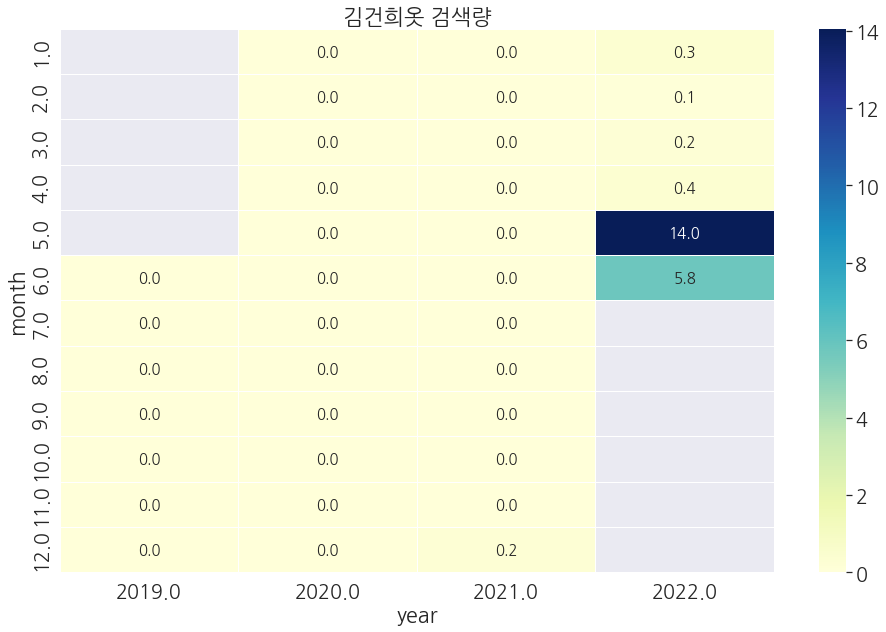

In [96]:
heatplot()

In [97]:
# heatplot_compare() ; 키워드 비교 열지도 시각화
def heatplot_compare():
    """
    '키워드1' vs '키워드2' 검색량을 비교해서 볼 수 있는 시계열 열지도 생성 함수입니다.
    """
    
    print("### 조회 가능한 키워드 정보 ###")
    print("=" * 50)
    print(df_m[['등장일자','키워드']])

    # keyword1, keyword2 = 조회할 키워드 입력
    keyword1 = input("검색량을 조회할 키워드1 입력 :")
    keyword2 = input("검색량을 조회할 키워드2 입력 :")
    
    # sns.heatmap
    # df_ym을 조회하려는 키워드의 검색량을 row = 월 / column = 년 으로 pivot 합니다.    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,10))
    sns.heatmap(df_ym.pivot("month", "year", keyword1), cmap="YlGnBu",
               annot=True, annot_kws={"size": 15}, fmt='.1f', linewidths=.5, ax=ax1)
    sns.heatmap(df_ym.pivot("month", "year", keyword2), cmap="YlGnBu",
               annot=True, annot_kws={"size": 15}, fmt='.1f', linewidths=.5, ax=ax2)
    ax1.set_title(keyword1 + " 검색량")
    ax2.set_title(keyword2 + " 검색량")
    plt.savefig('C:/project/CODE/keyword/data/fashion/figs/' + yesterday + '_' + keyword1 + 'vs' + keyword2 + '_히트맵차트.png', bbox_inches='tight')

### 조회 가능한 키워드 정보 ###
          등장일자                 키워드
0   2022-05-10                김건희옷
1   2022-05-12                 교련복
2   2022-05-12           마르조썸머인견팬츠
3   2022-05-12              반팔크롭자켓
4   2022-05-12               세루티자켓
5   2022-05-13           올리비아로렌티셔츠
6   2022-05-13          비비안마이핏네모팬티
7   2022-05-13             안나수이원피스
8   2022-05-13                 나이스
9   2022-05-14  행텐10320-150-404-51
10  2022-05-14                  리린
11  2022-05-14                  법복
12  2022-05-15            모르간썸머원피스
13  2022-05-15              한지민가디건
14  2022-05-15         스프리스기능성바람막이
15  2022-05-18                에바큐브
16  2022-05-18             여성정장하객룩
17  2022-05-18        나이키더블스우시후드집업
18  2022-05-19          마틴발썸머울카라니트
19  2022-05-19              여성여름정장
20  2022-05-20             유니클로마르니
21  2022-05-20               딜레탕티즘
22  2022-05-21              셀린느티셔츠
23  2022-05-21              닉스조거팬츠
24  2022-05-21         클로앤차이가디건형니트
25  2022-05-22            디키즈874여자
26  2022-05-22               반팔청자

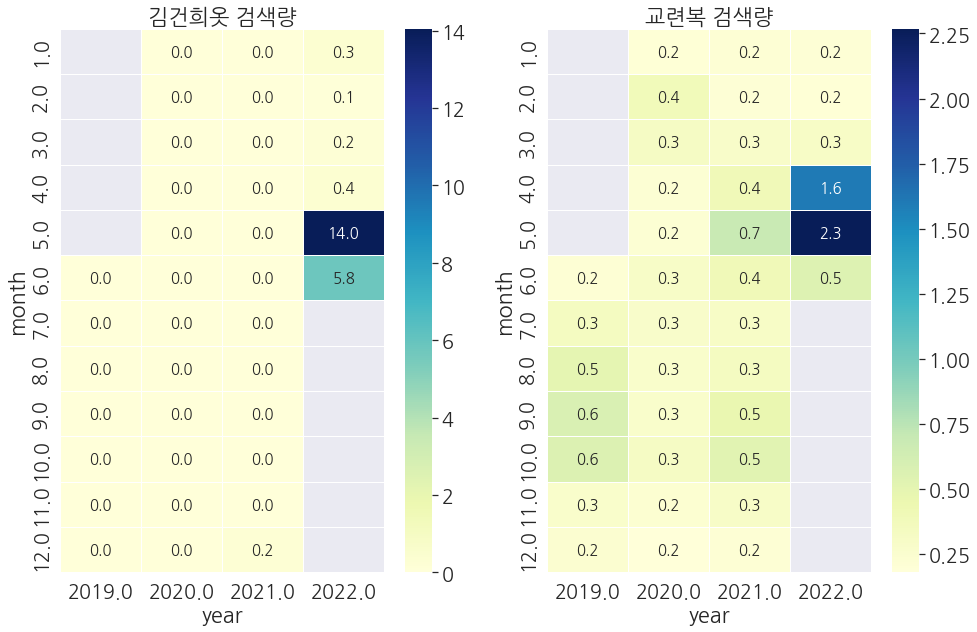

In [99]:
heatplot_compare()

# 키워드 네트워크 시각화 도전

In [81]:
# df_m = pd.read_csv('C:/project/CODE/keyword/data/fashion/output/' + yesterday + '_trendy_fashion_keywords.csv', encoding='UTF-8', index_col=0)
# lis = list(df_m['키워드'])
lis

['김건희옷',
 '교련복',
 '마르조썸머인견팬츠',
 '반팔크롭자켓',
 '세루티자켓',
 '올리비아로렌티셔츠',
 '비비안마이핏네모팬티',
 '안나수이원피스',
 '나이스',
 '행텐10320-150-404-51',
 '리린',
 '법복',
 '모르간썸머원피스',
 '한지민가디건',
 '스프리스기능성바람막이',
 '에바큐브',
 '여성정장하객룩',
 '나이키더블스우시후드집업',
 '마틴발썸머울카라니트',
 '여성여름정장',
 '유니클로마르니',
 '딜레탕티즘',
 '셀린느티셔츠',
 '닉스조거팬츠',
 '클로앤차이가디건형니트',
 '디키즈874여자',
 '반팔청자켓',
 '레이지카키하프조거팬츠',
 '테이퍼드세미와이드청바지',
 '트위드반팔',
 '마드제이',
 '테이핑브라',
 '여성반팔가디건',
 '유에르',
 '지오다노101221',
 '커클랜드티셔츠',
 '테니스원피스',
 '러브이즈트루',
 '가니송',
 '신혼부부',
 '리스트바지',
 '여성롱원피스',
 '폴로반팔셔츠',
 '리바이스쿨진여성',
 '엉뽕',
 '맥스튜어트뉴욕데님',
 '마리나요팅티셔츠',
 '바스락스커트',
 '비뮤즈맨션',
 '리더잭텐셀풀스트링팬츠',
 '올앤선드리원피스',
 '자바나스반팔',
 '세루티니트',
 '안지크원피스',
 '올리브그린썸머하이웨이팬츠',
 '코닥반팔티',
 '누모브라렛',
 '쌍방울하나만',
 '컬럼비아유니버시티']

In [111]:
word = lis[1]
url = 'https://search.naver.com/search.naver?where=nexearch&sm=top_hty&fbm=1&ie=utf8&query=' + lis[1]
r = requests.get(url)
soup_r = bs4.BeautifulSoup(r.text, 'lxml')

In [199]:
# 연관검색어 파싱

result = soup_r.select('ul.lst_related_srch > li.item')
related_words = []
for i in result:
    related_words.append(i.text.replace("  ",""))
related_words

['교련복 반티',
 '반티 교련복',
 '교련복 대여',
 '교련복 완장',
 '교련복 사진',
 '교련복 졸업사진',
 '교련복 반팔',
 '교련복 뜻',
 '교련복 모자',
 '졸업사진 교련복']

In [200]:
df_n = pd.DataFrame()
df_n['sub_word'] = related_words
df_n['sup_word'] = lis[1]
df_n

,sub_word,sup_word
0,교련복 반티,교련복
1,반티 교련복,교련복
2,교련복 대여,교련복
3,교련복 완장,교련복
4,교련복 사진,교련복
5,교련복 졸업사진,교련복
6,교련복 반팔,교련복
7,교련복 뜻,교련복
8,교련복 모자,교련복
9,졸업사진 교련복,교련복


In [21]:
def related_word_parse(word_list, n): 
    """
    검색어의 연관검색어를 반복해서 검색하는 함수입니다.
    ...
    word_list = 검색할 키워드 값이 있는 리스트
    n = 검색어의 연관검색어를 거듭진행할 회차 수 입력
    """
    if n==0:
        print('작업 종료')
        
    else:
        merge_df = pd.DataFrame()
        for i in tqdm(range(len(word_list))):
            temp_df = pd.DataFrame()
            temp_list = []
            url = 'https://search.naver.com/search.naver?where=nexearch&sm=top_hty&fbm=1&ie=utf8&query=' + word_list[i]
            r = requests.get(url)
            soup_r = bs4.BeautifulSoup(r.text, 'lxml')
            print(word_list[i])
            result = soup_r.select('ul.lst_related_srch > li.item')
            time.sleep(1)
            
            
            try:
                result = soup_r.select('ul.lst_related_srch > li.item')
            
            
            # 연관검색어가 없는 키워드일 때 예외처리
            except:
                if pd.isna(result):
                    result = []
                
                    
            if len(result) == 0:
                pass
            
            else:
                for k in result:
                    temp_list.append(k.text.replace("  ",""))
                
                temp_df['sub_word'] = temp_list
                temp_df['sup_word'] = word_list[i]
                temp_df = pd.DataFrame(temp_df, columns=['sup_word', 'sub_word'])
                
                merge_df = pd.concat([merge_df, temp_df], axis=0)
                
        # 반복회차 결과 저장
        dictionary[n] = merge_df

        # 반복호출
        pass_word_list = merge_df['sub_word'].values

        print('==========다음 회차 시작')
        related_word_parse(pass_word_list, n-1)


In [22]:
dictionary = {}
lis = write_keywords
related_word_parse(lis, 3)

  0%|          | 0/59 [00:00<?, ?it/s]

김건희옷
교련복
마르조썸머인견팬츠
반팔크롭자켓
세루티자켓
올리비아로렌티셔츠
비비안마이핏네모팬티
안나수이원피스
나이스
행텐10320-150-404-51
리린
법복
모르간썸머원피스
한지민가디건
스프리스기능성바람막이
에바큐브
여성정장하객룩
나이키더블스우시후드집업
마틴발썸머울카라니트
여성여름정장
유니클로마르니
딜레탕티즘
셀린느티셔츠
닉스조거팬츠
클로앤차이가디건형니트
디키즈874여자
반팔청자켓
레이지카키하프조거팬츠
테이퍼드세미와이드청바지
트위드반팔
마드제이
테이핑브라
여성반팔가디건
유에르
지오다노101221
커클랜드티셔츠
테니스원피스
러브이즈트루
가니송
신혼부부
리스트바지
여성롱원피스
폴로반팔셔츠
리바이스쿨진여성
엉뽕
맥스튜어트뉴욕데님
마리나요팅티셔츠
바스락스커트
비뮤즈맨션
리더잭텐셀풀스트링팬츠
올앤선드리원피스
자바나스반팔
세루티니트
안지크원피스
올리브그린썸머하이웨이팬츠
코닥반팔티
누모브라렛
쌍방울하나만
컬럼비아유니버시티
==========다음 회차 시작


  0%|          | 0/310 [00:00<?, ?it/s]

교련복 반티
반티 교련복
교련복 대여
교련복 완장
교련복 사진
교련복 졸업사진
교련복 반팔
교련복 뜻
교련복 모자
졸업사진 교련복
마르조썸머인견팬츠4종
허밍썸머인견팬츠
조이너스 릴렉스핏 인견팬츠
마르조와이드팬츠
반팔트위드자켓
린넨반팔자켓
반팔청자켓
노카라 반팔자켓
반팔 숏자켓
오버핏 반팔자켓
화이트크롭자켓
반팔크롭트위드
7부크롭자켓
배색 크롭자켓
세루티크롭자켓
세루티린넨자켓
세루티썸머자켓
세루티트위드자켓
세루티루센트자켓
온앤온 자켓
조이너스 자켓
더엣지 자켓
모르간자켓
세루티수트
올리비아로렌 반팔
올리비아로렌 나시
올리비아로렌7부
올리비아로렌하단점
올리비아로렌 광주진월점
비비안 마이핏 모달 네모팬티
비비안 네모팬티
비비안 모달 네모팬티
비비안 마이핏
비비안 사각팬티
안나수이자수원피스
하객원피스
잇미샤 원피스
린넨원피스
쉬폰 원피스
시슬리 원피스
온앤온 원피스
지컷 원피스
바스락원피스
베네통 원피스
나이스 학부모서비스
나이스지키미
나이스클랍
나이스 학생서비스
나이스고스트클럽
나이스 신용점수
나이스클랍 원피스
나이스파크
나이스평가정보
나이스 신용평가
10320-150-404-51
행텐
리린 블라우스
냥코 리린
리린원피스
리린쇼핑몰
해피어리린
생활법복
법복바지
법복조끼
법복세트
모르간원피스
썸머 원피스
스프리스 바람막이
기능성 바람막이
나이키 스우시 후드집업
나이키 더블스우시 후드티
나이키 더블스우시
나이키 더블스우시 바람막이
여성여름정장세트
여름여성정장
여성여름정장바지
여름여성정장세트
여성여름정장조끼
여름여성정장바지
여성여름바지정장
여성여름치마정장
여성여름정장베스트
중년여성여름정장
마르니 유니클로
유니클로 마르니 원피스
유니클로 마르니 자켓
유니클로 마르니 셔츠
유니클로 마르니 셋업
유니클로 마르니 매장
유니클로 마르니 바지
유니클로 마르니 스커트
유니클로 마르니 팬츠
유니클로 마르니 블라우스
셀린느 반팔
셀린느 옷
셀린느 맨투맨
셀린느 후드
셀린느 스트라이프
셀린느 나시
셀린느 크롭
셀린느 마차티
셀린느 마차
셀린느 설키
디키즈 874 여자 사이즈
디키즈 874

  0%|          | 0/1728 [00:00<?, ?it/s]

반티 교련복
반티
교련복
교련복
옛날교복 완장
교련복
교련 뜻
조이너스릴렉스핏인견팬츠3종
조이너스 인견팬츠
조이너스 릴렉스핏
마르조썸머와이드팬츠
마르조
퍼프트위드반팔자켓
루즈핏반팔트위드자켓
스퀘어넥반팔트위드자켓
린넨반팔자켓
반팔크롭자켓
노카라 반팔자켓
반팔 트위드 셋업
반팔 숏자켓
반팔크롭트위드
반팔카라트위드자켓
린넨반팔크롭자켓
반팔트위드자켓
반팔청자켓
노카라 반팔자켓
린넨7부자켓
린넨하프자켓
루즈핏반팔자켓
반팔 린넨 셋업
크롭반팔청자켓
반팔트위드자켓
린넨반팔자켓
반팔 숏자켓
얇은 청자켓
데님 청자켓
스판청자켓
7부청자켓
민소매청자켓
청자켓조끼
반팔트위드자켓
린넨반팔자켓
반팔크롭자켓
체크반팔자켓
오버핏 반팔자켓
노카라청자켓
반팔 퍼프 자켓
브이넥 반팔 자켓
라운드반팔자켓
스퀘어반팔자켓
숏반팔자켓
린넨반팔숏자켓
여성반팔숏자켓
미쏘 테일러드 일자핏 반팔 숏자켓
반팔자켓
반팔트위드자켓
린넨반팔자켓
반팔크롭자켓
노카라 반팔자켓
체크반팔자켓
루즈핏반팔자켓
반팔패드자켓
뒷트임반팔자켓
세루티 자켓
온앤온 린넨자켓
온앤온 반팔자켓
온앤온 크롭자켓
온앤온 청자켓
온앤온 숏자켓
온앤온 노카라 자켓
온앤온마자켓
온앤온 울자켓
온앤온 가죽자켓
온앤온 체크자켓
조이너스린넨자켓
조이너스7부자켓
조이너스청자켓
조이너스반팔자켓
조이너스가죽자켓
조이너스노카라자켓
쉬즈미스 자켓
리스트 자켓
로엠 자켓
모조에스핀 자켓
더엣지 린넨자켓
더엣지 보이핏자켓
트위드자켓
리스트 자켓
enc 자켓
톰보이 자켓
모르간자켓
까사렐 자켓
헤링본 자켓
지스튜디오 자켓
모르간린넨자켓
모르간반팔자켓
모르간크롭자켓
모르간텐션자켓
모르간트위드자켓
모르간가죽자켓
쉬즈미스 자켓
리스트 자켓
온앤온 자켓
지고트 자켓
올리비아로렌 셔츠
올리비아 로렌
비비안 마이핏 네모팬티
비비안 마이핏 모달 네모팬티
비비안 모달 네모팬티
비비안 심리스
비비안 마이핏 모달 네모팬티
비비안 마이핏 네모팬티
비너스 사각팬티
6월하객원피스
하객룩 원피스
하객 롱원피스
77하객원피스
결혼식 하객룩
린넨원피스
쉬폰 원피스
뷔스티에 원피스
데님 원피스


뉴발란스 테니스
일자롱원피스
일자미니원피스
린넨 일자 원피스
하객원피스
쉬폰 원피스
데님 원피스
스퀘어넥 원피스
트위드 원피스
블랙원피스
멜빵 원피스
롱원피스
하객원피스
쉬폰 원피스
멜빵 원피스
니트원피스
반팔원피스
테니스 원피스
캐주얼 원피스
면 원피스
오버핏 원피스
라코스테 원피스
써스데이아일랜드 원피스
롱원피스
하객원피스
잇미샤 원피스
뷔스티에 원피스
데님 원피스
폴로 원피스
타미힐피거 원피스
헤지스 원피스
러브이즈트루 반팔니트
러브이즈트루
시눈 반팔
러브이즈트루 니트
러브이즈트루 반팔
러브이즈트루 반팔니트
러브이즈트루
러브이즈트루 원피스
러브이즈트루 반팔
메쉬카라원피스
러브이즈트루 반팔
러브이즈트루 니트
러브이즈트루
러브이즈트루 원피스
라코스테 원피스
롱원피스
하객원피스
잇미샤 원피스
린넨원피스
쉬폰 원피스
뷔스티에 원피스
시슬리 원피스
지고트 원피스
온앤온 원피스
2022년 서울시 신혼부부 전세대출
2022년 경기도 신혼부부 전세대출
2022년 신혼부부 전세대출 소득
2022년 신혼부부 전세대출 조건
2022년 신혼부부 전세대출 한도
2022년 신혼부부 전세대출 이자
2022년 신혼부부 전세대출 금리
2022년 신혼부부 전세대출 서류
2022년 서울 신혼부부 전세대출
2022년 신혼부부 전세대출 경기도
2022년 신혼부부 매매대출 한도
2022년 신혼부부 매매대출 금리
2022년 신혼부부 매매대출 조건
2022년 신혼부부 매매대출 서류
2022년 신혼부부 매매대출 이자
2022년 신혼부부 전세대출
2022년 신혼부부 디딤돌대출
2022년 신혼부부 대출
신혼부부 매매대출
2022년 매매대출
신혼부부 특별공급 조건
신혼부부 특별공급 소득
2022년 신혼부부 특별공급 조건
신혼부부 특별공급 점수
신혼부부 특별공급 추첨
2022년 신혼부부 특별공급
무주택신혼부부 특별공급
신혼부부 특별공급 대출
2022 신혼부부 특별공급
신혼부부 특별공급 자동차
신혼부부 컵선물
개업선물
이사선물
신혼집 선물
결혼식 선물
센스있는선물
커플선물
웨딩선물
신혼부부 머그컵
신혼부부 

In [24]:
dictionary[3]

,sup_word,sub_word
0,교련복,교련복 반티
1,교련복,반티 교련복
2,교련복,교련복 대여
3,교련복,교련복 완장
4,교련복,교련복 사진
...,...,...
3,코닥반팔티,코닥 메일러
4,코닥반팔티,코닥 뷰파인더
5,코닥반팔티,코닥 반팔니트
6,코닥반팔티,코닥 워싱 반팔


In [25]:
dictionary[2]

,sup_word,sub_word
0,교련복 반티,반티 교련복
1,교련복 반티,반티
2,교련복 반티,교련복
0,교련복 대여,교련복
0,교련복 완장,옛날교복 완장
...,...,...
1,코닥 맨투맨,코닥맨투맨 가방
2,코닥 맨투맨,코닥맨투맨 기장
3,코닥 맨투맨,코닥맨투맨 셔츠
4,코닥 맨투맨,코닥맨투맨 로고


In [23]:
dictionary[1]

,sup_word,sub_word
0,반티,체육대회 반티
1,반티,야쿠자 반티
2,반티,하이큐 반티
3,반티,군복 반티
4,반티,새마을 반티
...,...,...
7,코닥 바지,캉골 바지
8,코닥 바지,팀버랜드 바지
9,코닥 바지,코닥숏팬츠
0,코닥 셋업,코닥 옷


In [66]:
merge1 = pd.merge(dictionary[3], dictionary[2], left_on='sub_word', right_on='sup_word')
merge2 = pd.merge(dictionary[2], dictionary[1], left_on='sub_word', right_on='sup_word')
merge2

,sup_word_x,sub_word_x,sup_word_y,sub_word_y
0,교련복 반티,반티,반티,체육대회 반티
1,교련복 반티,반티,반티,야쿠자 반티
2,교련복 반티,반티,반티,하이큐 반티
3,교련복 반티,반티,반티,군복 반티
4,교련복 반티,반티,반티,새마을 반티
...,...,...,...,...
38756,코닥 옷,코닥 바지,코닥 바지,캉골 바지
38757,코닥 옷,코닥 바지,코닥 바지,팀버랜드 바지
38758,코닥 옷,코닥 바지,코닥 바지,코닥숏팬츠
38759,코닥 옷,코닥 셋업,코닥 셋업,코닥 옷


In [68]:
merge1 = merge1.drop(['sub_word_x'], axis=1)
merge1.columns = ['sup_word', 'sub_word1','sub_word2']
merge1

,sup_word,sub_word1,sub_word2
0,교련복,교련복 반티,반티 교련복
1,교련복,교련복 반티,반티
2,교련복,교련복 반티,교련복
3,교련복,교련복 대여,교련복
4,교련복,교련복 완장,옛날교복 완장
...,...,...,...
2037,코닥반팔티,코닥 맨투맨,코닥맨투맨 가방
2038,코닥반팔티,코닥 맨투맨,코닥맨투맨 기장
2039,코닥반팔티,코닥 맨투맨,코닥맨투맨 셔츠
2040,코닥반팔티,코닥 맨투맨,코닥맨투맨 로고


In [69]:
merge2 = merge2.drop(['sup_word_x', 'sub_word_x'], axis=1)
merge2.columns = ['drop', 'sub_word3']
merge2

,drop,sub_word3
0,반티,체육대회 반티
1,반티,야쿠자 반티
2,반티,하이큐 반티
3,반티,군복 반티
4,반티,새마을 반티
...,...,...
38756,코닥 바지,캉골 바지
38757,코닥 바지,팀버랜드 바지
38758,코닥 바지,코닥숏팬츠
38759,코닥 셋업,코닥 옷


In [8]:
total_words = pd.merge(merge1, merge2, left_on='sub_word2', right_on='drop')
total_words = total_words.drop(['drop'], axis=1)
total_words.to_csv('C:/project/CODE/keyword/data/fashion/network/multiple_related_word_parse.csv', encoding='utf-8')
total_words

NameError: name 'total_words' is not defined

## 여기서부터는 임시 작업 구간 ##

In [18]:
##### 여기서부터는 임시 작업용 df 호출 #####
# total_words = pd.read_csv('C:/project/CODE/keyword/data/fashion/network/multiple_related_word_parse.csv', encoding='utf-8', index_col=0)
dupl = total_words.drop_duplicates(['sup_word'], keep='first')
lis = list(dupl['sup_word'])

In [22]:
is_sup = total_words['sup_word']  == lis[0]
df_sup = total_words[is_sup]
df_sup

,sup_word,sub_word1,sub_word2,sub_word3
0,교련복,교련복 반티,반티,체육대회 반티
1,교련복,교련복 반티,반티,야쿠자 반티
2,교련복,교련복 반티,반티,하이큐 반티
3,교련복,교련복 반티,반티,군복 반티
4,교련복,교련복 반티,반티,새마을 반티
...,...,...,...,...
278,교련복,교련복 뜻,교련복,교련복 모자
279,교련복,교련복 뜻,교련복,졸업사진 교련복
280,교련복,교련복 완장,옛날교복 완장,완장
281,교련복,교련복 완장,옛날교복 완장,교련복 완장


In [110]:
## 조회를 원하는 키워드 명을 input 으로 받는 형태가 나을까나 ~?~?
def create_nx(keyword_name):
    """
    트렌드 키워드의 연관검색어들 
    """
    # 라이브러리
    import networkx as nx
    import matplotlib.font_manager as fm ; from matplotlib import rc
    # 폰트 설정
    font_name = fm.FontProperties(fname="c:/Windows/Fonts/HMKMMAG.ttf").get_name()
    

    # 네트워크 생성
    G = nx.Graph()
    
    for sup in list(set(keyword_name['sup_word'].values)):
        G.add_node(sup)
        temp_df1 = keyword_name[keyword_name['sup_word']==sup]
        for sub1 in list(set(temp_df1['sub_word1'].values)):
            G.add_node(sub1)
            G.add_edge(sup,sub1)
            temp_df2 = temp_df1[temp_df1['sub_word1']==sub1]
            for sub2 in list(set(temp_df2['sub_word2'].values)):
                G.add_node(sub2)
                G.add_edge(sub1,sub2)
                temp_df3 = temp_df2[temp_df2['sub_word2']==sub2]
                for sub3 in list(set(temp_df3['sub_word3'].values)):
                    G.add_node(sub3)
                    G.add_edge(sub2,sub3)
                    
        
    color_map = []
    i = 0
    for node in G:
        if node == lis[i]:
            color_map.append('red')
        elif node in list(set(keyword_name['sub_word1'].values)):
            color_map.append('yellow')
        else:
            color_map.append('violet')
        i+=1
            
    # 그래프 생성
    plt.figure(figsize=(24, 16))
    d = dict(G.degree)
    nx.draw(G,nodelist=d.keys(), node_size=[v * 500 for v in d.values()], font_family=font_name,font_size=30, node_color = color_map, with_labels = True)
    # 한글 폰트에러 때문에 별도의 폰트 설정이 필요합니다.
    plt.axis('off')
    plt.savefig('C:/project/CODE/keyword/data/fashion/figs/' + yesterday + 'networkx_pic.png')
    plt.show()
        

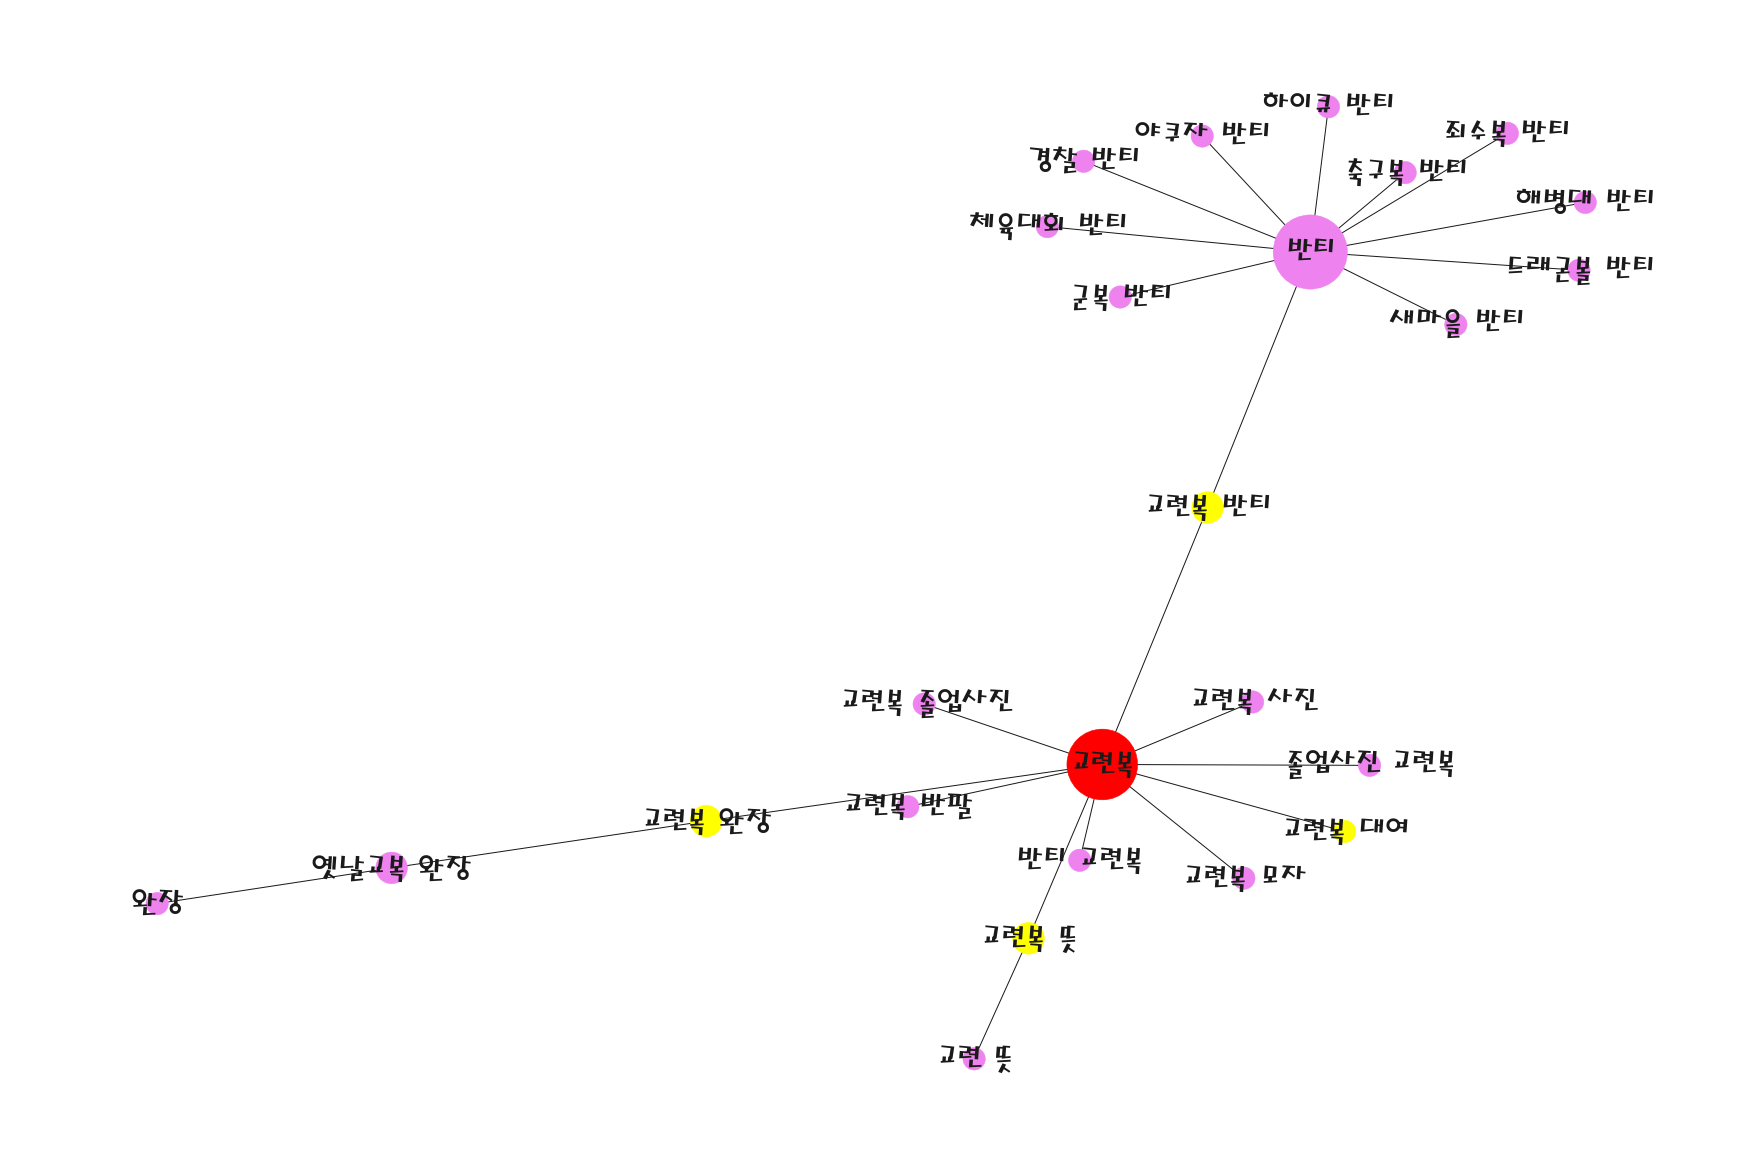

In [109]:
create_nx(df_sup)

# 키워드 네트워크 분석 시각화

In [1]:
import networkx as nx

# 키워드 형태소분석 도전

In [12]:
# 라이브러리
import konlpy
import pickle

from konlpy.tag import Okt
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


In [13]:
# from konlpy.tag import Okt
# okt 예시
okt = Okt()
print(okt.nouns(read_keywords)) # nouns = 명사

NameError: name 'read_keywords' is not defined

In [5]:
df_konlpy = pd.read_csv('C:/project/CODE/keyword/data/fashion/output/' + yesterday + '_trendy_fashion_keywords.csv', encoding='UTF-8', index_col=0)
write_keywords = list(df_konlpy['키워드'])
write_keywords

NameError: name 'pd' is not defined

In [9]:
df_konlpy = pd.read_csv('C:/project/CODE/keyword/data/fashion/output/2022-06-09_trendy_fashion_keywords.csv', encoding='UTF-8', index_col=0)
write_keywords = list(df_konlpy['키워드'])
write_keywords

['김건희옷',
 '교련복',
 '마르조썸머인견팬츠',
 '반팔크롭자켓',
 '세루티자켓',
 '올리비아로렌티셔츠',
 '비비안마이핏네모팬티',
 '안나수이원피스',
 '나이스',
 '행텐10320-150-404-51',
 '리린',
 '법복',
 '모르간썸머원피스',
 '한지민가디건',
 '스프리스기능성바람막이',
 '에바큐브',
 '여성정장하객룩',
 '나이키더블스우시후드집업',
 '마틴발썸머울카라니트',
 '여성여름정장',
 '유니클로마르니',
 '딜레탕티즘',
 '셀린느티셔츠',
 '닉스조거팬츠',
 '클로앤차이가디건형니트',
 '디키즈874여자',
 '반팔청자켓',
 '레이지카키하프조거팬츠',
 '테이퍼드세미와이드청바지',
 '트위드반팔',
 '마드제이',
 '테이핑브라',
 '여성반팔가디건',
 '유에르',
 '지오다노101221',
 '커클랜드티셔츠',
 '테니스원피스',
 '러브이즈트루',
 '가니송',
 '신혼부부',
 '리스트바지',
 '여성롱원피스',
 '폴로반팔셔츠',
 '리바이스쿨진여성',
 '엉뽕',
 '맥스튜어트뉴욕데님',
 '마리나요팅티셔츠',
 '바스락스커트',
 '비뮤즈맨션',
 '리더잭텐셀풀스트링팬츠',
 '올앤선드리원피스',
 '자바나스반팔',
 '세루티니트',
 '안지크원피스',
 '올리브그린썸머하이웨이팬츠',
 '코닥반팔티',
 '누모브라렛',
 '쌍방울하나만',
 '컬럼비아유니버시티']

In [10]:
#제목 및 본문 txt에 저장
text = open('trash.txt','w',encoding='UTF-8')
for i in write_keywords:
    text.write(i)
    text.write(" ") # 띄어쓰기 구분
text.close()

In [14]:
# text 파일 읽어오기
blog_text = open('trash.txt','rt', encoding='UTF-8').read()
# print("블로그 텍스트 내용: " + blog_text)

# Okt 함수를 이용해 형태소 분석
okt = Okt()
line =[]

line = okt.pos(blog_text)

n_adj =[]
# 명사 또는 형용사인 단어만 n_adj에 넣어주기
for word, tag in line:
    if tag in ['Noun']:
        n_adj.append(word)

# print(n_adj)

# 불용어 사전
f = open("C:/project/CODE/keyword/data/stopwords/stopwords_korean.txt", "rt", encoding="utf-8")
lines = f.readlines()
stop_words = []
for line in lines:
    line = line.replace('\n', '') #txt 읽을 때 \n 제거
    stop_words.append(line)
f.close()
# stop_words

n_adj = [word for word in n_adj if not word in stop_words]
print("한글자 처리 전 단어 총 개수:" + str(len(n_adj)))

# print(line)
# print(n_adj)

remove_one_word = [x for x in n_adj if len(x)>1 or x=='핏' or x=='청' or x=='롱' or x=='티']
print("한글자 처리 후 단어 총 개수:" + str(len(remove_one_word)))


#가장 많이 나온 단어 100개 저장
counts = Counter(n_adj)
tags = counts.most_common(100)



# 이미지 추가(워드 클라우드 모양 설정)

# mask = Image.new("RGBA",(2500,2500), (255,255,255)) #(2500,2500) = 이미지 크기, (255,255,255) = RGB
# image = Image.open('C:/project/img/square.png').convert("RGBA")
# x,y = image.size
# mask.paste(image,(0,0,x,y),image)
# mask = np.array(mask)

# ### 워드 클라우드 생성 ###
# #폰트지정
# # sns.set(style='darkgrid', font='NanumGothic', font_scale=1.2)
# font='C:/Users/User/AppData/Local/Microsoft/Windows/Fonts/MALGUN.ttf'
# word_cloud = WordCloud(font_path=font, background_color='black',max_font_size=400, mask=mask,colormap='prism').generate_from_frequencies(dict(tags))


# # 사이즈 설정 및 화면에 출력
# plt.figure(figsize=(10,8))
# plt.imshow(word_cloud)
# plt.axis('off')
# #워드클라우드 사진으로 저장
# #cloud.to_file('네이버_키워드_블로그_워드클라우드.png')
# #또는
# plt.savefig('C:/project/CODE/keyword/data/fashion/wordcloud/' + yesterday + 'wordcloud.png', bbox_inches='tight')
# plt.show()



한글자 처리 전 단어 총 개수:151
한글자 처리 후 단어 총 개수:131


In [15]:
n_adj

['김건희',
 '옷',
 '교련',
 '복',
 '마르',
 '썸머',
 '인견',
 '팬츠',
 '크롭',
 '자켓',
 '루티',
 '자켓',
 '올리비아',
 '로렌',
 '티셔츠',
 '비비안',
 '마이',
 '핏',
 '네모',
 '팬티',
 '안나',
 '수이',
 '원피스',
 '나이스',
 '행텐',
 '리린',
 '법복',
 '간',
 '썸머',
 '원피스',
 '한지민',
 '가디건',
 '스프리스',
 '기능',
 '바람막이',
 '에바',
 '큐브',
 '정장',
 '하객',
 '나이키',
 '더블',
 '스',
 '우시',
 '후드',
 '집업',
 '마틴',
 '발',
 '썸머',
 '카라',
 '니트',
 '여성',
 '여름',
 '정장',
 '유니클로',
 '딜레탕티즘',
 '셀린느',
 '티셔츠',
 '닉스',
 '조거',
 '팬츠',
 '앤',
 '차이',
 '가디건',
 '니트',
 '디',
 '키즈',
 '여자',
 '청',
 '자켓',
 '레이지',
 '카키',
 '하프',
 '조거',
 '팬츠',
 '테이',
 '퍼드',
 '세미',
 '와이드',
 '청바지',
 '트',
 '위드',
 '마드',
 '제이',
 '테이',
 '핑',
 '브라',
 '가디건',
 '유',
 '에르',
 '지오다노',
 '커클랜드',
 '티셔츠',
 '테니스',
 '원피스',
 '러브',
 '이즈',
 '트루',
 '가니송',
 '신혼부부',
 '리스트',
 '바지',
 '여성',
 '롱',
 '원피스',
 '폴로',
 '셔츠',
 '리바이',
 '스쿨',
 '진여성',
 '뽕',
 '맥',
 '스튜어트',
 '뉴욕',
 '데님',
 '마리나',
 '팅',
 '티셔츠',
 '바스락',
 '스커트',
 '비',
 '뮤즈',
 '맨션',
 '리더',
 '잭',
 '텐셀풀스트',
 '링',
 '팬츠',
 '앤선',
 '원피스',
 '자바',
 '나스',
 '루티',
 '니트',
 '안',
 '지크',
 '원피스',
 '올리브',
 '그린',
 

In [16]:
from pykospacing import Spacing

In [17]:
spacing = Spacing()

In [18]:
for item in write_keywords:
    kospacing_item = spacing(item)
    print(kospacing_item)

1/1 [==============================] - 0s 444ms/step
김건희 옷
1/1 [==============================] - 0s 25ms/step
교련복
1/1 [==============================] - 0s 21ms/step
마르조 썸머 인 견 팬츠
1/1 [==============================] - 0s 23ms/step
반팔크롭자켓
1/1 [==============================] - 0s 23ms/step
세루티 자켓
1/1 [==============================] - 0s 33ms/step
올리비아로 렌티셔츠
1/1 [==============================] - 0s 35ms/step
비비안 마이핏 네모 팬티
1/1 [==============================] - 0s 37ms/step
안나수 이 원피스
1/1 [==============================] - 0s 22ms/step
나이스
1/1 [==============================] - 0s 23ms/step
행텐 10320-150-404-51
1/1 [==============================] - 0s 25ms/step
리린
1/1 [==============================] - 0s 23ms/step
법복
1/1 [==============================] - 0s 24ms/step
모르간 썸머 원피스
1/1 [==============================] - 0s 32ms/step
한지민 가디건
1/1 [==============================] - 0s 34ms/step
스프리스 기능성 바람막이
1/1 [==============================] - 0s 25ms/step
에바큐브
1/1 [=====================

In [103]:
# shapes
"""
1개월 이내 네이버 패션의류 탑 500 신규 진입 키워드들의 최근 1개월간 평균 검색량을 추출한 데이터프레임입니다.
"""
shapes = df_vis.copy()
shapes = shapes.truncate(before=time_month)
shapes = shapes.mean()
shapes = shapes.reset_index()
shapes.columns = ['keyword', 'month_avg_query']
shapes = shapes[:-2]
shapes = shapes.sort_values('month_avg_query', ascending=False).reset_index(drop=True)
shapes.head(20)

C:\Users\User\AppData\Local\Temp\ipykernel_20456\3092077136.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  shapes = shapes.mean()


,keyword,month_avg_query
0,리린,28.500079
1,김건희옷,15.449799
2,나이스,13.570576
3,운동화,13.052885
4,유니클로마르니,8.887810
5,마드제이,2.224100
6,디키즈874여자,1.889672
7,교련복,1.583467
8,폴로반팔셔츠,1.495555
9,셀린느티셔츠,1.452009


<AxesSubplot:title={'center':'최근 1개월 이내 네이버 패션의류 탑 500 신규 진입 키워드'}>

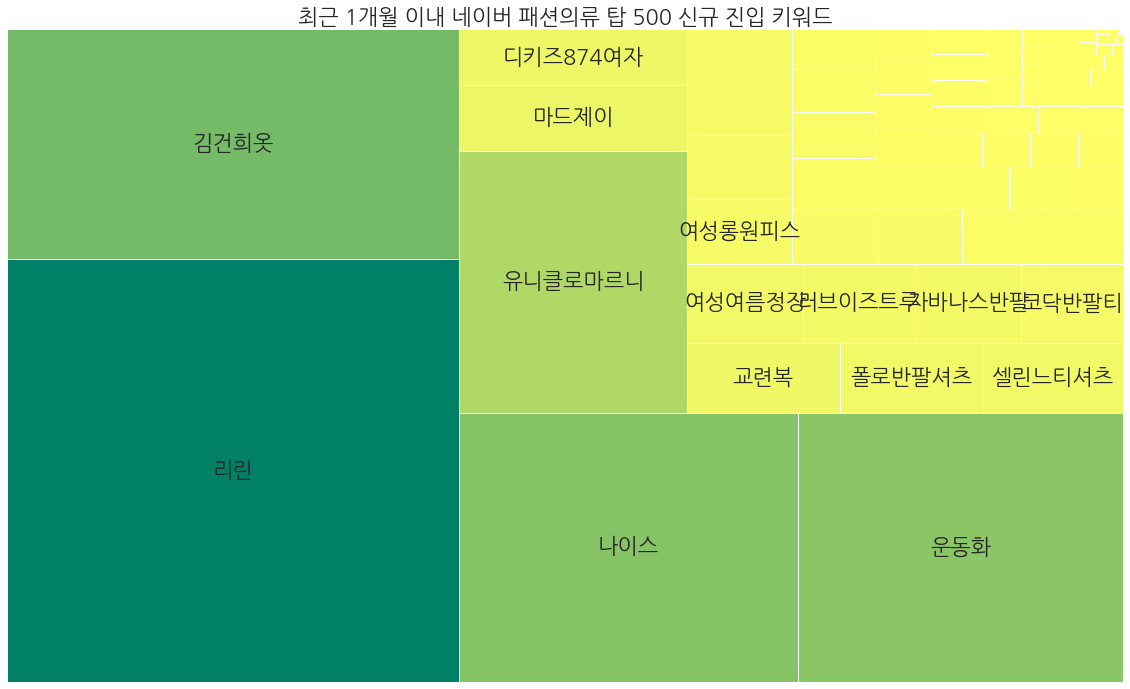

In [107]:
# 색상지도 시각화
cmap = matplotlib.cm.summer_r
norm = matplotlib.colors.Normalize(vmin=shapes.month_avg_query.min(), vmax=shapes.month_avg_query.max())
colors = [cmap(norm(value)) for value in shapes.month_avg_query]

# 연도별 블로그, 카페 건수 트리맵
plt.figure(figsize=(20,12)); plt.axis('off') ; plt.title("최근 1개월 이내 네이버 패션의류 탑 500 신규 진입 키워드")
squarify.plot(
    sizes=shapes.month_avg_query,
    color=colors,
    label=shapes.apply(lambda x: str(x.keyword) if x.month_avg_query >= 1 else '', axis=1),
    alpha=1)
